# Monolayer

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
from pauli_matrices import tau_0, tau_z, sigma_0, tau_x, sigma_z
plt.rcParams.update({
  "text.usetex": True,
})

## Diagonalization

In [2]:
def get_Hamiltonian(k_x, k_y, mu, B, Delta, phi_x):
    """Return the Hamiltonian for a given k."""
    return 1/2 * ( (  ( k_x + phi_x )**2 + k_y**2 - mu ) * np.kron( ( tau_0 + tau_z )/2, sigma_0)
                   - ( ( -k_x + phi_x )**2 + k_y**2 - mu ) * np.kron( ( tau_0 - tau_z )/2, sigma_0)
                   - B * np.kron(tau_0, sigma_z)
                   - Delta * np.kron(tau_x, sigma_0)
                 )

def get_Energies(k_x_values, k_y_values, mu, B, Delta, phi_x):
    """Return the energies of the Hamiltonian at a given k."""
    E = np.zeros((len(k_x_values), len(k_y_values), 4))
    for i, k_x in enumerate(k_x_values):
        for j, k_y in enumerate(k_y_values):
            H = get_Hamiltonian(k_x, k_y, mu, B, Delta, phi_x)
            E[i, j, :] = np.linalg.eigvalsh(H)
    return E

def get_Energy(k_x, k_y, mu, B, Delta, phi_x):
    return get_Energies([k_x], [k_y], mu, B, Delta, phi_x)

def get_Analytic_Energy(k_x, k_y, mu, B, Delta, phi_x):
    return np.array([-B/2 + k_x * phi_x - 1/2 * np.sqrt(Delta**2 + ( k_x**2 + k_y**2 - mu + phi_x**2 )**2),
                     B/2 + k_x * phi_x - 1/2 * np.sqrt(Delta**2 + ( k_x**2 + k_y**2 - mu + phi_x**2 )**2),
                     -B/2 + k_x * phi_x + 1/2 * np.sqrt(Delta**2 + ( k_x**2 + k_y**2 - mu + phi_x**2 )**2),
                     B/2 + k_x * phi_x + 1/2 * np.sqrt(Delta**2 + ( k_x**2 + k_y**2 - mu + phi_x**2 )**2)
                    ])
def get_Analytic_Energy_polar(k, theta, mu, B, Delta, phi_x):
    return np.array([-B/2 + k * np.cos(theta) * phi_x - 1/2 * np.sqrt(Delta**2 + ( k**2 - mu + phi_x**2 )**2),
                 B/2 + k * np.cos(theta) * phi_x - 1/2 * np.sqrt(Delta**2 + ( k**2 - mu + phi_x**2 )**2),
                 -B/2 + k * np.cos(theta) * phi_x + 1/2 * np.sqrt(Delta**2 + ( k**2 - mu + phi_x**2 )**2),
                 B/2 + k * np.cos(theta) * phi_x + 1/2 * np.sqrt(Delta**2 + ( k**2 - mu + phi_x**2 )**2)
                ])

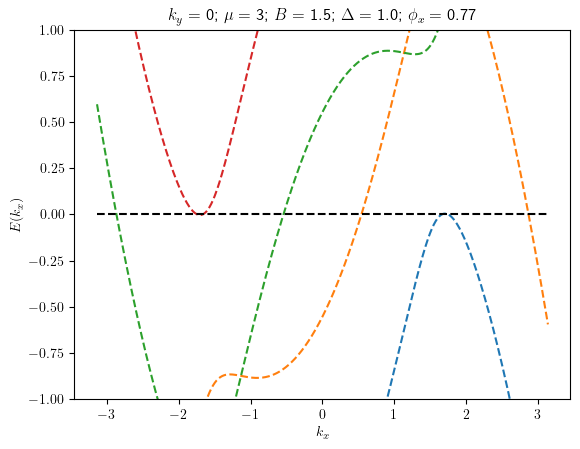

In [168]:
k_x_values = np.linspace(-np.pi, np.pi, 1000)
k_y = 0
mu = 3
Delta = 1.
B = 1.5
phi_x = 0.77
Energies = get_Energies(k_x_values, [k_y], mu, B, Delta, phi_x)
Analytic_Energies = get_Analytic_Energy(k_x_values, k_y, mu, B, Delta, phi_x)

fig, ax = plt.subplots()
for i in range(4):
    ax.plot(k_x_values, Analytic_Energies[i, :], linestyle="dashed")
    #ax.plot(k_x_values, Energies[:, :, i])
ax.set_xlabel(r"$k_x$")
ax.set_ylabel(r"$E(k_x)$")
ax.set_title(r"$k_y=$" + f"{k_y:2}"
             + r"; $\mu=$ " + f"{mu:2}"
             + r"; $B=$ " + f"{B:.2}"
             + r"; $\Delta=$ " + f"{Delta:.2}"
             + r"; $\phi_x=$ " + f"{phi_x}"
            )
ax.set_ylim(-1, 1)
ax.hlines(0, -np.pi, np.pi, "k", linestyles="dashed")
plt.show()

## Eigenvalues

$$E_{\pm,\pm}(k_x, k_y) = \pm \frac{B}{2} + k_x\phi_x \pm \frac{1}{2}\sqrt{\Delta^2+(k_x^2+k_y^2-\mu+\phi_x^2)^2}$$

## Bogoliubov-Fermi pockets

In [214]:
import warnings

def get_theta(k, mu, B, Delta, phi_x):
    """Returns the values of polar angle theta for
        a given k belonging to the Bogoliubov-Fermi surface."""
    theta_values = []
    # use lambda functions to avoid evaluation
    cos_theta_analytic = lambda alpha, beta: ( alpha * B + beta * np.sqrt(Delta**2 + ( k**2 - mu + phi_x**2 )**2) )/( 2 * k * phi_x)
    for i, alpha in enumerate([-1, 1]):
        for j, beta,  in enumerate([-1, 1]):
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    theta = np.arccos(cos_theta_analytic(alpha, beta))
                except:
                    theta_values.append(None)
                    theta_values.append(None)
                else:
                    theta_values.append(theta)
                    theta_values.append(theta + np.pi)
    return np.array(sorted(theta_values, key=lambda x: (x is None, x)))

def get_roots_k_y_equal_zero(mu, B, Delta, phi_x):
    roots_1 = np.roots([-1, 0, (2*phi_x**2 + 2*mu), 4*B*phi_x, B**2 - Delta**2 - (phi_x**2-mu)**2])
    roots_2 = np.roots([-1, 0, (2*phi_x**2 + 2*mu), -4*B*phi_x, B**2 - Delta**2 - (phi_x**2-mu)**2])
    roots = np.sort(np.append(roots_1, roots_2))
    roots = np.real( roots[np.isclose(roots.imag, 0)] )
    roots_list = []
    for r in roots:
        roots_list.append([r, 0])
    return roots_list

def get_roots_k_x_equal_zero(mu, B, Delta, phi_x):
    critical = []
    critical.append([0, np.sqrt(mu - phi_x**2 + np.sqrt(B**2 - Delta**2))])
    critical.append([0, -np.sqrt(mu - phi_x**2 + np.sqrt(B**2 - Delta**2))])
    critical.append([0, np.sqrt(mu - phi_x**2 - np.sqrt(B**2 - Delta**2))])
    critical.append([0, -np.sqrt(mu - phi_x**2 - np.sqrt(B**2 - Delta**2))])
    return critical

def get_critical_points(mu, B, Delta, phi_x):
    roots_k_y = [_ for _ in get_roots_k_y_equal_zero(mu, B, Delta, phi_x) if _[0]>0]
    roots_k_x = [_ for _ in get_roots_k_x_equal_zero(mu, B, Delta, phi_x) if _[1]>0]
    matrix = np.append(np.array(roots_k_y), np.array(roots_k_x), axis=0)
    row_norms = np.linalg.norm(matrix, axis=1)
    sorted_matrix = matrix[np.argsort(row_norms)]
    return sorted_matrix

def get_Discriminant_roots(mu, B, Delta):
    coefficients = [-4096 * (B - mu) * (B + mu),
                    0,
                    -2048 * mu * (-4 * B**2 + Delta**2 + 4 * mu**2),
                    0,
                    -256 * (8 * B**4 + 20 * B**2 * Delta**2
                             - Delta**4
                             + 8 * (B**2 - 4 * Delta**2) * mu**2 - 16 * mu**4),
                    0,
                    512 * mu * (4 * B**4 + B**2 * Delta**2 - 5 * Delta**4
                                 -4 * (B**2 + Delta**2) * mu**2 ),
                    0,
                    -256 * (B**2 - Delta**2)**2 * (B**2 - Delta**2 - mu**2)
                   ]
    roots = np.roots(coefficients)
    roots = np.real( roots[np.isclose(roots.imag, 0)] )
    roots = np.sort([r for r in roots if r >=0])
    return roots

def get_region_number(mu, B, Delta, phi_x):
    roots = get_Discriminant_roots(mu, B, Delta)
    if B >= Delta:
        if phi_x < roots[0]:
            return 1
        elif (roots[0] <= phi_x <= roots[1]) and  (roots[0] <= phi_x <= np.sqrt(mu - np.sqrt(B**2 - Delta**2))):
            return 2
        elif (roots[1] < phi_x <= np.sqrt(mu - np.sqrt(B**2 - Delta**2))):
            return 3

def get_theta_limits(k, mu, B, Delta, phi_x):
    """Returns a list of list whose first element is the number of negative energy bands
        for a given k."""
    theta_values = get_theta(k, mu, B, Delta, phi_x)
    non_None_values = theta_values[theta_values!=None]
    roots = get_critical_points(mu, B, Delta, phi_x)
    region = get_region_number(mu, B, Delta, phi_x)
    if region == 2:    # Region 2
        if 0 <= k <= np.linalg.norm(roots[0]):
            return [[ 2, [0, 1], ( 0, 2*np.pi ) ]]
        elif np.linalg.norm(roots[0]) <= k < np.linalg.norm(roots[1]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 1], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 1], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[1]) <= k < np.linalg.norm(roots[2]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 2], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 2], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[2]) <= k < np.linalg.norm(roots[3]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 1], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 1], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[3]) <= k:
            return [[ 2, [0, 1], ( 0, 2*np.pi ) ]]
    elif region == 1:     # Region 1
        if 0 <= k <= np.linalg.norm(roots[0]):
            return [[ 2, [0, 1], ( 0, 2*np.pi ) ]]
        elif np.linalg.norm(roots[0]) <= k < np.linalg.norm(roots[1]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 1], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 1], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[1]) <= k < np.linalg.norm(roots[2]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 2], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 2], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[2]) <= k <= np.linalg.norm(roots[3]):
            return [[ 2, [0, 2], ( 0, 2*np.pi ) ]]
        elif np.linalg.norm(roots[3]) < k < np.linalg.norm(roots[4]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 2], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 2], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[4]) <= k < np.linalg.norm(roots[5]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 1], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 1], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[5]) <= k:
            return [[ 2, [0, 1], ( 0, 2*np.pi ) ]]
    elif region == 3:    # Region 3
        if 0 <= k <= np.linalg.norm(roots[0]):
            return [[ 2, [0, 1], ( 0, 2*np.pi ) ]]
        elif np.linalg.norm(roots[0]) <= k < np.linalg.norm(roots[1]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 1], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 1], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[1]) <= k < np.linalg.norm(roots[2]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 2], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 2], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[2]) <= k < np.linalg.norm(roots[3]):
            return [[0, [], (0, non_None_values[0])],
                    [1, [0], (non_None_values[0], non_None_values[1])],
                    [2, [0, 2], (non_None_values[1], non_None_values[2])],
                    [3, [0, 1, 2], (non_None_values[2], non_None_values[3])],
                    [4, [0, 1, 2, 3], (non_None_values[3], non_None_values[4])],
                    [3, [0, 1, 2], (non_None_values[4], non_None_values[5])],
                    [2, [0, 2], (non_None_values[5], non_None_values[6])],
                    [1, [0], (non_None_values[6], non_None_values[7])],
                    [0, [], (non_None_values[7], 2*np.pi)]]
        elif np.linalg.norm(roots[3]) <= k < np.linalg.norm(roots[4]):
            if roots[3][0] == 0:
                return [[0, [], (0, non_None_values[0])],
                        [1, [0], (non_None_values[0], non_None_values[1])],
                        [2, [0, 1], (non_None_values[1], non_None_values[2])],
                        [3, [0, 1, 2], (non_None_values[2], non_None_values[3])],
                        [4, [0, 1, 2, 3], (non_None_values[3], non_None_values[4])],
                        [3, [0, 1, 2], (non_None_values[4], non_None_values[5])],
                        [2, [0, 1], (non_None_values[5], non_None_values[6])],
                        [1, [0], (non_None_values[6], non_None_values[7])],
                        [0, [], (non_None_values[7], 2*np.pi)]]
            elif roots[3][1] == 0:
                return [[1, [0], (0, non_None_values[0])],
                        [2, [0, 2], (non_None_values[0], non_None_values[1])],
                        [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                        [2, [0, 2], (non_None_values[2], non_None_values[3])],
                        [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[4]) <= k < np.linalg.norm(roots[5]):
            return [[1, [0], (0, non_None_values[0])],
                    [2, [0, 1], (non_None_values[0], non_None_values[1])],
                    [3, [0, 1, 2], (non_None_values[1], non_None_values[2])],
                    [2, [0, 1], (non_None_values[2], non_None_values[3])],
                    [1, [0], (non_None_values[3], 2*np.pi)]]
        elif np.linalg.norm(roots[5]) <= k:
            return [[ 2, [0, 1], ( 0, 2*np.pi ) ]]
def pocket_approximation(X, Y, mu, B, Delta, phi_x):
    roots = get_roots_k_y_equal_zero(mu, B, Delta, phi_x)
    k = np.sqrt(X**2 + Y**2)
    boolean_matrix = ( (X - (roots[2]+roots[7])/2)**2 + Y**2 >= ((roots[2]-roots[7])/2)**2 ) * ( (X-(roots[1]+roots[4])/2)**2 + Y**2 <= ((roots[1]-roots[4])/2)**2 )
    return boolean_matrix


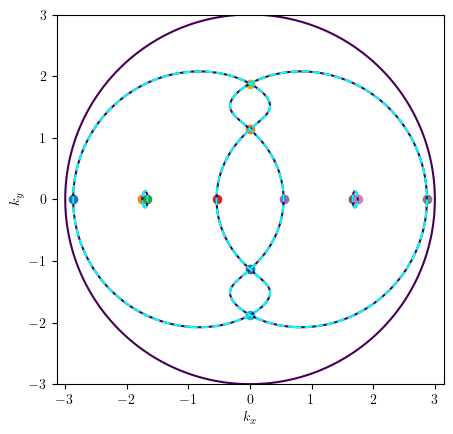

In [169]:
fig, ax = plt.subplots()
k_x_values = np.linspace(-np.pi, np.pi, 1000)
k_y_values = np.linspace(-np.pi, np.pi, 1000)
X, Y = np.meshgrid(k_x_values, k_y_values)

for i in range(4):
    ax.contour(X, Y, get_Analytic_Energy(X, Y, mu, B, Delta, phi_x)[i], levels=[0.0])
if phi_x == 0:
    ax.contour(X, Y, -B + np.sqrt(Delta**2 + ( (X)**2 + Y**2 - mu )**2),
              colors="red", levels=[0.], linestyles="dashed")
else:
    ax.contour(X, Y, X - ( -B + np.sqrt(Delta**2 + ( X**2 + Y**2 - mu + phi_x**2 )**2) )/( 2 * phi_x),
              levels=[0.0], colors="cyan", linestyles="dashed")
    ax.contour(X, Y, X - ( B - np.sqrt(Delta**2 + ( X**2 + Y**2 - mu + phi_x**2 )**2) )/( 2 * phi_x),
              levels=[0.0], colors="cyan", linestyles="dashed")
    ax.contour(X, Y, X - ( -B - np.sqrt(Delta**2 + ( X**2 + Y**2 - mu + phi_x**2 )**2) )/( 2 * phi_x),
              levels=[0.0], colors="cyan", linestyles="dashed")
    ax.contour(X, Y, X - ( B + np.sqrt(Delta**2 + ( X**2 + Y**2 - mu + phi_x**2 )**2) )/( 2 * phi_x),
              levels=[0.0], colors="cyan", linestyles="dashed")

roots = get_roots_k_y_equal_zero(mu, B, Delta, phi_x)

for i in range(len(roots)):
    ax.scatter(roots[i][0], 0)

k = 3
theta_values = get_theta(k, mu, B, Delta, phi_x)
theta_values = theta_values[np.isclose(theta_values.imag, 0)]
for i in range(len(theta_values)):
    if theta_values[i] is not None:
        k_x_values = np.linspace(-k, k)
        ax.plot(k_x_values, k_x_values * np.tan(theta_values[i]))
ax.contour(X, Y, X**2 + Y**2 - k**2, levels=[0.0])  #plot of a circle of radius k

ax.scatter(0, np.sqrt(mu - phi_x**2 + np.sqrt(B**2 - Delta**2))) #special point
ax.scatter(0, -np.sqrt(mu - phi_x**2 + np.sqrt(B**2 - Delta**2)))
ax.scatter(0, -np.sqrt(mu - phi_x**2 - np.sqrt(B**2 - Delta**2)))
ax.scatter(0, np.sqrt(mu - phi_x**2 - np.sqrt(B**2 - Delta**2)))

"""
ax.contour(X, Y, (X-(roots[0]+roots[5])/2)**2 + Y**2 - ((roots[0]-roots[5])/2)**2, levels=[0.0],
          colors=["red"])  #plot of a circle of radius k
ax.contour(X, Y, (X-(roots[3]+roots[7])/2)**2 + Y**2 - ((-roots[3]+roots[7])/2)**2, levels=[0.0],
          colors=["black"])  #plot of a circle of radius k
ax.contour(X, Y, (X-(roots[1]+roots[4])/2)**2 + Y**2 - ((roots[1]-roots[4])/2)**2, levels=[0.0],
          colors=["blue"])  #plot of a circle of radius k
ax.contour(X, Y, (X-(roots[2]+roots[7])/2)**2 + Y**2 - ((roots[2]-roots[7])/2)**2, levels=[0.0],
          colors=["green"])  #plot of a circle of radius k

ax.contour(X, Y, pocket_approximation(X, Y, mu, B, Delta, phi_x),
           levels=[0.], colors=["orange"])
"""
ax.set_xlabel(r"$k_x$")
ax.set_ylabel(r"$k_y$")
ax.set_ylim(-3, 3)
ax.set_aspect("equal")

plt.show()

The equation for the pockets is simple if $\phi_x=0$
$$ k^2 =  \mu \pm \sqrt{B^2 - \Delta^2} \;\;\;\;\;\;\;\;\;\;\;\; B>\Delta$$

With $\phi_x \neq 0$ it results in four implicit equations:
$$ k_x = \frac{\pm B \pm \sqrt{\Delta^2 + (k^2 - \mu + \phi_x^2)^2}}{2\phi_x}, $$
where $\pm$ can take all the possibles combinations.

In polar coordinates, since $k_x=k\cos\theta$, the pocket has the following dependence
$$\theta_{\pm,\pm} = \arccos\left( \frac{\pm B \pm \sqrt{\Delta^2 + (k^2 - \mu + \phi_x^2)^2}}{2k\phi_x} \right)$$

For $k_y=0$, the $k_x$ of the pockets are the roots of the following polynomial (8 in total):

$$-k_x^4 + k_x^2 (2\phi_x^2 + 2\mu) \pm 4B\phi_x k_x + B^2 - \Delta^2 - (\phi_x^2 - \mu)^2 = 0$$

By solving the discriminant of this last equation we can know when 0, 1 or 2 pairs of pockets appear

$-256 \left(B^6-B^4 \left(3 \Delta ^2+\mu ^2+8 \mu  \phi ^2-8 \phi ^4\right)+B^2 \left(3 \Delta ^4+2 \Delta ^2 \left(\mu ^2-\mu  \phi ^2+10 \phi ^4\right)+8 \phi ^2 \left(\mu ^3+\mu ^2 \phi ^2-4 \mu  \phi ^4+2 \phi ^6\right)\right)-\left(\Delta ^2-4 \mu  \phi ^2\right)^2 \left(\Delta ^2+\left(\mu -\phi ^2\right)^2\right)\right)$

which can be solved for $\phi$ for specific values $\mu=1, B=2\Delta, \Delta=0.2$

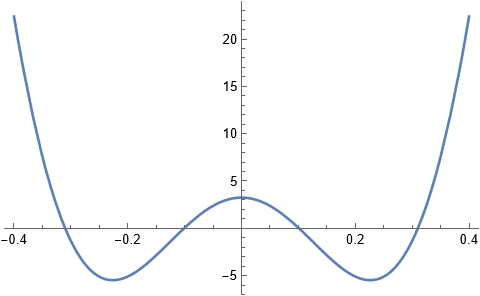!

The roots corresponds to the critical values $\phi_c$ where where new pockets appear.
For $k_x=0$,

$$k_y = \pm \sqrt{\mu - \phi_x^2 \pm \sqrt{B^2 - \Delta^2}}$$
and the critical values are $\phi_c=\mu$ and $\phi_c=\pm |\mu\pm\sqrt{B^2-\Delta^2}|$

In [6]:
def integrand(k, mu, B, Delta, phi_x):
    L = get_theta_limits(k, mu, B, Delta, phi_x)
    integrand = 0
    for i, L_row in enumerate(L):
        theta_1, theta_2 = L_row[2]
        if L_row[0] == 2:   
            if L_row[1] == [0, 1]:    # region A
                integrand += ( k * ( 2 * k * phi_x * ( np.sin(theta_2) - np.sin(theta_1) )
                                 - np.sqrt( Delta**2 + ( k**2 - mu + phi_x**2 )**2 ) * (theta_2 - theta_1)
                                   )
                             )
            else:                     # region B L_row[1] == [0, 2]
                integrand += ( k * ( 2 * k * phi_x * ( np.sin(theta_2) - np.sin(theta_1) )
                                 - B * (theta_2 - theta_1)
                                   )
                             )
        elif L_row[0] == 1:
            integrand += ( k * ( k * phi_x * ( np.sin(theta_2) - np.sin(theta_1) )
                             - 1/2 * ( B + np.sqrt( Delta**2 + ( k**2 - mu + phi_x**2 )**2 ) ) * (theta_2 - theta_1)
                               )
                         )
        elif L_row[0] == 3:
            integrand += ( k * ( 3 * k * phi_x * ( np.sin(theta_2) - np.sin(theta_1) )
                             - 1/2 * ( B + np.sqrt( Delta**2 + ( k**2 - mu + phi_x**2 )**2 ) ) * (theta_2 - theta_1)
                               )
                         )
        elif L_row[0] == 4:
            integrand += ( 4 * k**2 * phi_x * ( np.sin(theta_2) - np.sin(theta_1) )
                         )
        elif L_row[0] == 0:
            integrand += 0
    return integrand

In [193]:
k = 3 
phi_x = 0.77
theta_values = get_theta(k, mu, B, Delta, phi_x)
roots = get_critical_points(mu, B, Delta, phi_x)
print(theta_values)
print(roots)
print(get_theta_limits(k, mu, B, Delta, phi_x))
print(integrand(k, mu, B, Delta, phi_x))

[None None None None None None None None]
[[0.54331229 0.        ]
 [0.         1.13537043]
 [1.66620758 0.        ]
 [1.74828363 0.        ]
 [0.         1.87753402]
 [2.87117892 0.        ]]
[[2, [0, 1], (0, 6.283185307179586)]]
-125.69464289035497


In [8]:
scipy.integrate.quad(integrand, 0, 3, args=(mu, B, Delta, 0.1))

(-85.6190055613997, 7.008239890637924e-07)

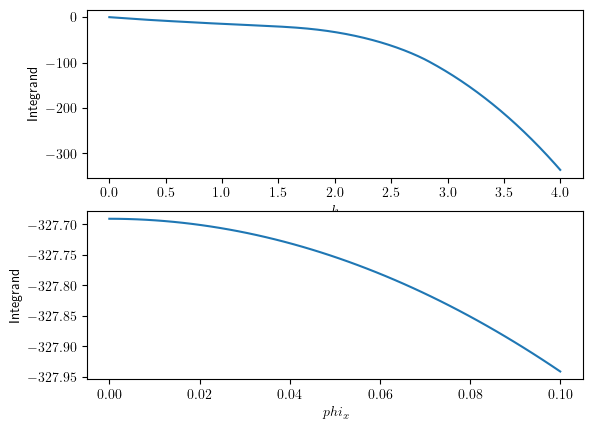

In [52]:
fig, axs = plt.subplots(2, 1)
cut_off = 4
k = np.linspace(0, cut_off, 3000)
phi_x = 0.6
points = np.linalg.norm(get_critical_points(mu, B, Delta, phi_x), axis=1)
#print(points)
axs[0].plot(k, [integrand(k, mu, B, Delta, phi_x) for k in k])
#axs[0].scatter(points, [integrand(point, mu, B, Delta, phi_x) for point in points])
axs[0].set_xlabel(r"$k$")
axs[0].set_ylabel(r"Integrand")

phi_x_values = np.linspace(0, 0.1)
axs[1].plot(phi_x_values, [integrand(cut_off, mu, B, Delta, phi_x) for phi_x in phi_x_values])
#ax.scatter(points, -15 * np.ones_like(points) )
axs[1].set_xlabel(r"$phi_x$")
axs[1].set_ylabel(r"Integrand")

plt.show()

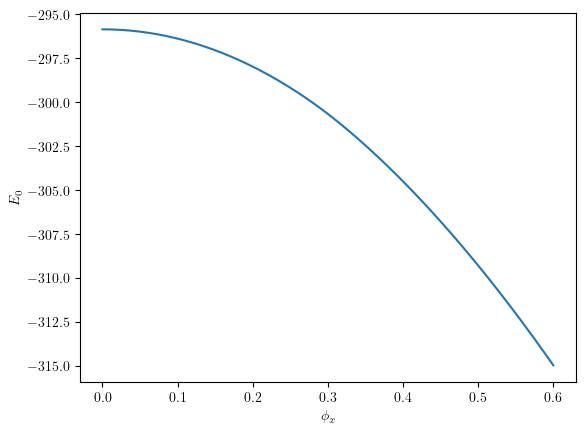

In [53]:
def get_fundamental_energy(phi_x, mu, B, Delta):
    if phi_x == 0:
        return scipy.integrate.quad(integrand, 0, cut_off, args=(mu, B, Delta, phi_x))
    else:
        points = np.linalg.norm(get_critical_points(mu, B, Delta, phi_x), axis=1)
        return scipy.integrate.quad(integrand, 0, cut_off, args=(mu, B, Delta, phi_x), points=points)
def get_fundamental_energy_vs_phi_x(phi_x_values, mu, B, Delta):
    E = np.zeros_like(phi_x_values)
    error = np.zeros_like(phi_x_values)
    for i, phi_x in enumerate(phi_x_values):
        E[i], error[i] = get_fundamental_energy(phi_x, mu, B, Delta)
        #E[i] = E[i] + 2*np.pi * (10**3/3 - 10*mu + 10**2*phi_x + 10*phi_x**2)
    return E, error

cut_off = 4
mu = 3
Delta = 1
B = 2 * Delta
phi_x_values = np.linspace(0, 0.6)
E, error = get_fundamental_energy_vs_phi_x(phi_x_values, mu, B, Delta)
fig, ax = plt.subplots()
ax.plot(phi_x_values, E)
ax.set_xlabel(r"$\phi_x$")
ax.set_ylabel(r"$E_0$")
plt.show()

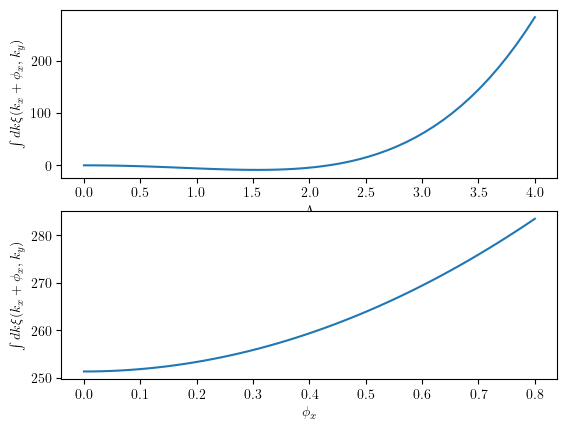

In [29]:
phi_x = 0.8
cut_off = 4

fig, axs = plt.subplots(2, 1)
f = lambda k: 2*np.pi * (k**4/4 + (phi_x**2 - mu)*k**2/2)
g = lambda phi_x: 2*np.pi * (cut_off**4/4 + (phi_x**2 - mu)*cut_off**2/2)
phi_x_values = np.linspace(0, 0.8)
cut_off_values = np.linspace(0, 4)

axs[0].plot(cut_off_values, [f(k) for k in cut_off_values])
axs[0].set_xlabel(r"$\Lambda$")
axs[0].set_ylabel(r"$\int dk \xi(k_x + \phi_x,k_y)$")

axs[1].plot(phi_x_values, [g(k) for k in phi_x_values])
axs[1].set_xlabel(r"$\phi_x$")
axs[1].set_ylabel(r"$\int dk \xi(k_x + \phi_x,k_y)$")
plt.show()

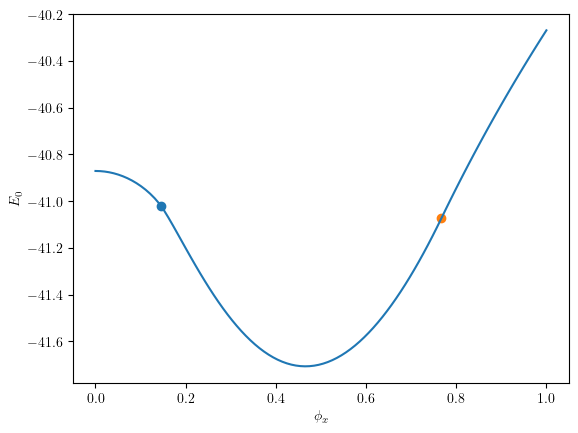

In [237]:
def get_total_fundamental_energy_vs_phi_x(phi_x_values, mu, B, Delta, cut_off):
    E = np.zeros_like(phi_x_values)
    error = np.zeros_like(phi_x_values)
    for i, phi_x in enumerate(phi_x_values):
        #print(phi_x)
        E[i], error[i] = get_fundamental_energy(phi_x, mu, B, Delta)
        E[i] = E[i] + 2*np.pi * (cut_off**4/4 + (phi_x**2 - mu) * cut_off**2/2 )
    return E, error
    
cut_off = 5
mu = 3.
Delta = 1
B = 1.5 * Delta
phi_x_values = np.linspace(0, 1, 100)

E, error = get_total_fundamental_energy_vs_phi_x(phi_x_values, mu, B, Delta, cut_off)
fig, ax = plt.subplots()
ax.plot(phi_x_values, E)
ax.set_xlabel(r"$\phi_x$")
ax.set_ylabel(r"$E_0$")

Discriminant_roots = get_Discriminant_roots(mu, B, Delta)
for r in Discriminant_roots:
    ax.scatter(r, get_total_fundamental_energy_vs_phi_x([r], mu, B, Delta, cut_off)[0])

plt.show()

In [229]:
roots = get_critical_points(mu, B, Delta, phi_x)
roots

array([[0.72649401, 0.        ],
       [1.38145663, 0.        ],
       [0.        , 1.50509984],
       [0.        , 1.59651949],
       [2.09335491, 0.        ],
       [2.74831753, 0.        ]])

In [230]:
Discriminant_roots = get_Discriminant_roots(mu, B, Delta)
Discriminant_roots

array([0.00288716, 0.59814508])

In [206]:
roots = get_critical_points(mu, B, Delta, Discriminant_roots[0])
roots

array([[1.19345703, 0.        ],
       [0.        , 1.36406665],
       [0.        , 2.02404194],
       [2.208076  , 0.        ]])

In [152]:
 roots

array([[0.54331229, 0.        ],
       [0.        , 1.13537043],
       [1.66620758, 0.        ],
       [1.74828363, 0.        ],
       [0.        , 1.87753402],
       [2.87117892, 0.        ]])

In [181]:
Discriminant_roots = get_Discriminant_roots(mu, B, Delta)
Discriminant_roots

array([0.14590474, 0.76716644])

In [223]:
get_total_fundamental_energy_vs_phi_x([Discriminant_roots[0]], mu, B, Delta, cut_off)

(array([-38.71633456]), array([2.33469495e-06]))